In [1]:
import numpy as np
from myplotstyle import plt, get_figsize

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from itertools import combinations
from astropy.table import Table
from astropy.coordinates import SkyCoord
from SAGA.utils import add_skycoord, binned_percentile
from SAGA.utils.distance import z2v
import bottleneck as bn

In [2]:
from fast_histogram import histogram1d

def myhistogram(a, bins=10, range=None, density=None, weights=None, use_numpy=False):
    if not use_numpy:
        if range is None and not isinstance(bins, int):
            range = (bins[0], bins[-1])
            bins = len(bins) - 1
        try:
            h = histogram1d(a, bins, range, weights)
        except TypeError:
            pass
        else:
            return (h / len(a),) if density else (h,)
    return np.histogram(a, bins, range, density, weights)

In [3]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [4]:
hosts = saga.host_catalog.load(query="paper3", include_stats=True)

In [5]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [6]:
sats = C.is_sat.filter(base)
sats = add_skycoord(sats)
sats["index"] = np.arange(len(sats))
del base
print(len(sats))

378


In [7]:
sdss_x = np.linspace(0, 180, 19)[:-1] + 5
sdss_y = np.array([0.64268367, 0.44155338, 0.4841401 , 0.4633828 , 0.4685856 ,
       0.58841093, 0.54086203, 0.64018368, 0.48222288, 0.51515562,
       0.52488057, 0.55817479, 0.51704362, 0.47159272, 0.44232658,
       0.47630996, 0.58469492, 0.49163754])

In [8]:
_X = []
for sats_this in sats[["HOSTID", "index"]].group_by('HOSTID').groups:
    if len(sats_this) < 2:
        continue
    for i, j in combinations(range(len(sats_this)), 2):
        _X.append((sats_this["index"][i], sats_this["index"][j]))

pairs = Table(np.array(_X, dtype=np.dtype([('idx1', np.int64), ('idx2', np.int64)])))
del sats_this, _X

assert (sats["HOSTID"][pairs["idx1"]] == sats["HOSTID"][pairs["idx2"]]).all()
assert (sats["OBJID"][pairs["idx1"]] != sats["OBJID"][pairs["idx2"]]).all()

In [9]:
from scipy.stats import norm

def calc_same_sign_prob(v1, v2, verr=1):
    a = norm.sf(v1, scale=verr)
    b = norm.sf(v2, scale=verr)
    return a * b + (1-a) * (1-b)

In [10]:
pairs["HOSTID"] = sats["HOSTID"][pairs["idx1"]]
_host_coord = SkyCoord(sats['HOST_RA'][pairs["idx1"]], sats['HOST_DEC'][pairs["idx1"]], unit="deg")

pairs["dv1"] = z2v(sats['SPEC_Z'][pairs["idx1"]]) - sats['HOST_VHOST'][pairs["idx1"]]
pairs["dv2"] = z2v(sats['SPEC_Z'][pairs["idx2"]]) - sats['HOST_VHOST'][pairs["idx2"]]
pairs["dv"] = np.abs(pairs["dv1"] - pairs["dv2"])
pairs["same_sign_prob"] = calc_same_sign_prob(pairs["dv1"], pairs["dv2"], 60.)

pairs["d1"] = sats['RHOST_KPC'][pairs["idx1"]]
pairs["d2"] = sats['RHOST_KPC'][pairs["idx2"]]

In [11]:
def add_pa(pairs, random=False):
    pairs = pairs.copy()
    if not random:
        pairs["pa1"] = sats["coord"][pairs["idx1"]].position_angle(_host_coord).degree
        pairs["pa2"] = sats["coord"][pairs["idx2"]].position_angle(_host_coord).degree
    else:
        n_max = max(pairs["idx1"].max(), pairs["idx2"].max()) + 1
        pa = np.random.RandomState(random).rand(n_max) if isinstance(random, int) else np.random.rand(n_max)
        pa *= 360.0
        pairs["pa1"] = pa[pairs["idx1"]]
        pairs["pa2"] = pa[pairs["idx2"]]

    pairs["dpa"] = np.abs(pairs["pa1"] - pairs["pa2"])
    pairs["opening_angle"] = np.where(pairs["dpa"] < 180, 180-pairs["dpa"], pairs["dpa"]-180)
    pairs["corotating_prob"] = np.where(pairs["opening_angle"] < 90, 1-pairs["same_sign_prob"], pairs["same_sign_prob"])
    pairs["corotating"] = pairs["corotating_prob"] >= 0.5

    _x1 = pairs["d1"] * np.cos(np.deg2rad(pairs["pa1"]))
    _y1 = pairs["d1"] * np.sin(np.deg2rad(pairs["pa1"]))
    _x2 = pairs["d2"] * np.cos(np.deg2rad(pairs["pa2"]))
    _y2 = pairs["d2"] * np.sin(np.deg2rad(pairs["pa2"]))
    pairs["d_center"] = np.hypot((_x1 + _x2) * 0.5, (_y1 + _y2) * 0.5)
    pairs["sep"] = np.hypot((_x1 - _x2), (_y1 - _y2))

    return pairs

In [12]:
dv_cut = Query('abs(dv1) > 25', 'abs(dv2) > 25')
#dv_cut = Query('corotating_prob > 0.6666') | Query('corotating_prob < 0.3333')
radius_cut = Query("d1 < 150", "d2 < 150")

pairs = add_pa(pairs)
print(dv_cut.count(pairs))
print((dv_cut & radius_cut).count(pairs))
print((~dv_cut).count(pairs))

578
126
257


In [13]:
p_rand = []
p_inner_rand = []
hist_rand = []
hist_inner_rand = []
hist_sep_rand = []
hist_sep_so_rand = []
dv_rand = []

bins = np.linspace(0, 180, 11)
sbins = np.linspace(0, 320, 9)

for i in range(5000):
    pairs = add_pa(pairs, random=i)

    hist_co = myhistogram(Query('corotating', dv_cut).filter(pairs, 'opening_angle'), bins)[0]
    hist_all = myhistogram(dv_cut.filter(pairs, 'opening_angle'), bins)[0]
    hist_co_inner = myhistogram(Query('corotating', dv_cut, radius_cut).filter(pairs, 'opening_angle'), bins)[0]
    hist_all_inner = myhistogram(Query(dv_cut, radius_cut).filter(pairs, 'opening_angle'), bins)[0]

    p_rand.append(hist_co/hist_all)
    p_inner_rand.append(hist_co_inner/hist_all_inner)
    hist_rand.append(hist_all)
    hist_inner_rand.append(hist_all_inner)

    hist_sep_rand.append(myhistogram(pairs['sep'], sbins)[0])
    hist_sep_so_rand.append(myhistogram(Query("opening_angle > 162", dv_cut).filter(pairs, 'sep'), sbins)[0])

    dv_rand.append(binned_percentile(pairs['sep'], pairs["dv"], bins=sbins, percentiles=[50, 16, 84])[2])

<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_13297/216044492.py:51: SyntaxWarning: invalid escape sequence '\c'
  ax[1,0].set_xlabel('Opening angle ($180^\circ - \Delta \phi$ ) [deg]');


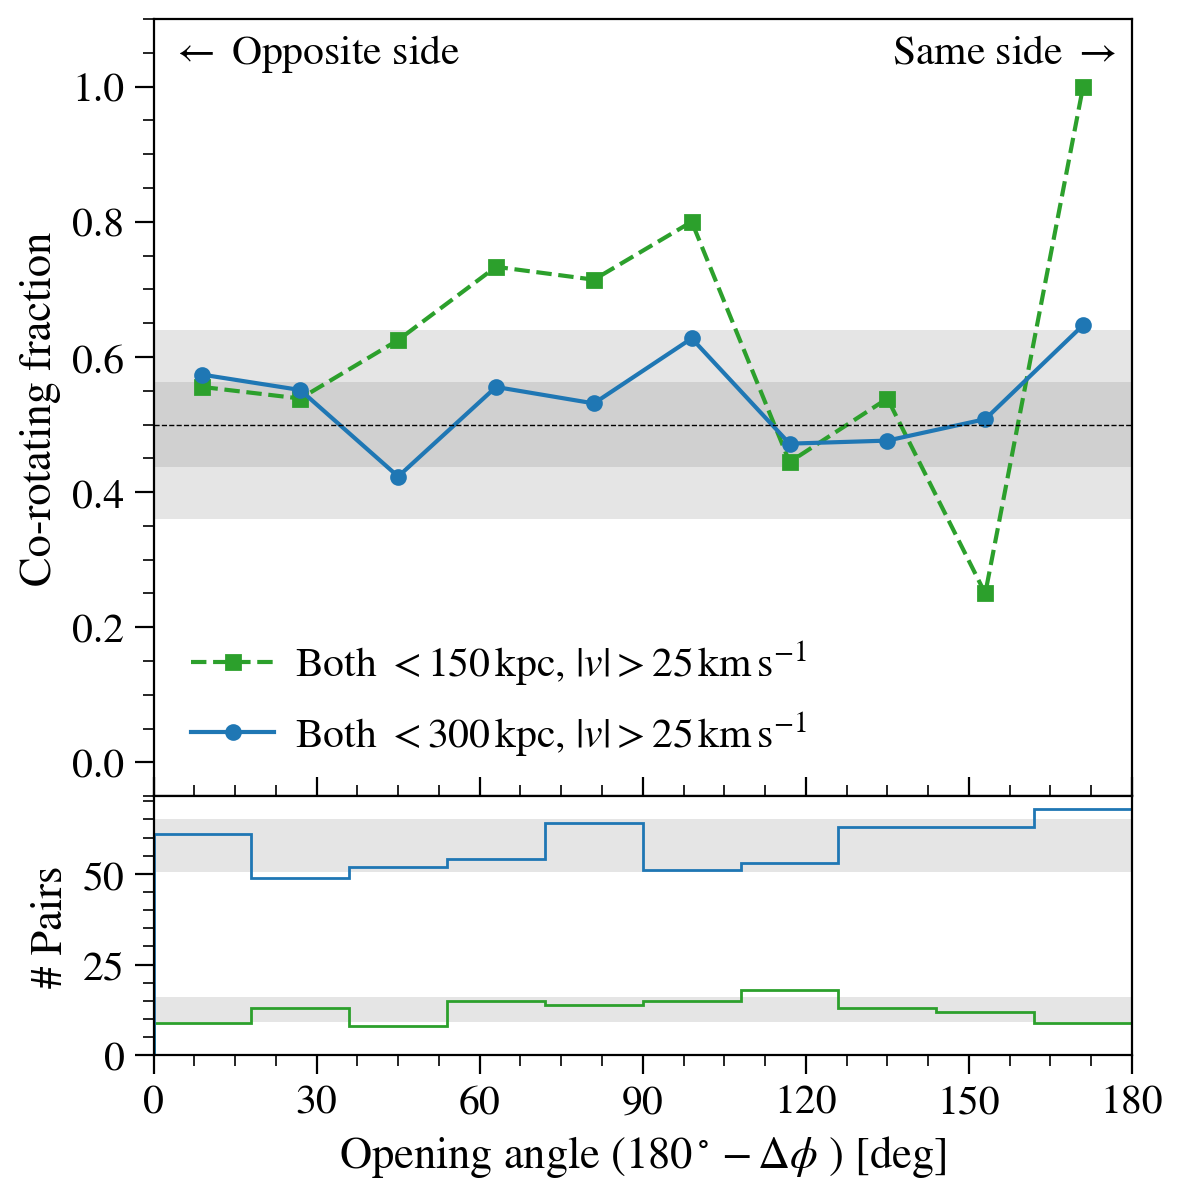

In [14]:
pairs = add_pa(pairs)

fig, ax = plt.subplots(2, 1, figsize=get_figsize(wide=False, ratio=1), height_ratios=(3,1))
ax = np.array([[ax[0], None], [ax[1], None]])
fig.set_constrained_layout_pads(hspace=0, h_pad=0)

ye = bn.nanstd(p_rand, axis=0).mean()
ax[0,0].axhspan(0.5-ye, 0.5+ye, color="grey", alpha=0.2, lw=0)
ye = bn.nanstd(p_inner_rand, axis=0).mean()
ax[0,0].axhspan(0.5-ye, 0.5+ye, color="grey", alpha=0.2, lw=0)

ym = bn.nanmean(hist_rand, axis=0).mean()
ye = bn.nanstd(hist_rand, axis=0).mean()
ax[1,0].axhspan(ym-ye, ym+ye, color="grey", alpha=0.2, lw=0)

ym = bn.nanmean(hist_inner_rand, axis=0).mean()
ye = bn.nanstd(hist_inner_rand, axis=0).mean()
ax[1,0].axhspan(ym-ye, ym+ye, color="grey", alpha=0.2, lw=0)

ax_this = ax[0,0]

bins = np.linspace(0, 180, 11)
x = (bins[1:]+bins[:-1]) * 0.5

hist_co_inner = np.histogram(Query('corotating', dv_cut, radius_cut).filter(pairs, 'opening_angle'), bins)[0]
hist_all_inner = ax[1,0].hist(Query(dv_cut, radius_cut).filter(pairs, 'opening_angle'), bins, color="C2", histtype="step")[0]
ax[0,0].plot(x, hist_co_inner/hist_all_inner, ls="--", color="C2", marker='s', label=r"Both $<150\,$kpc, $|v|>25\,$km$\,$s$^{-1}$");

hist_co = np.histogram(Query('corotating', dv_cut).filter(pairs, 'opening_angle'), bins)[0]
hist_all = ax[1,0].hist(dv_cut.filter(pairs, 'opening_angle'), bins, histtype="step")[0]
ax[0,0].plot(x, hist_co/hist_all, ls="-", color="C0", marker="o", label=r"Both $<300\,$kpc, $|v|>25\,$km$\,$s$^{-1}$");

#ax[0,0].plot(sdss_x, sdss_y, c="C8", ls=":", marker="^", label="SDSS (Phillips+ 2015, Fig. 3b)")

ax[0,0].text(3, 1.05, r"$\leftarrow$ Opposite side", va="center")
ax[0,0].text(177, 1.05, r"Same side $\rightarrow$", ha="right", va="center")
#ax[0,0].plot([],[],  color="C3", marker="^", ls=":", label="All pairs")

ax[0,0].legend(loc="lower left")
ax[0,0].tick_params(axis="x", which="both", direction="in")
ax[0,0].set_xlim(0, 180.0);
ax[0,0].set_xticks([0,30,60,90,120,150,180], labels=[])
ax[0,0].axhline(0.5, c='k', ls='--', lw=0.5);

ax[0,0].set_ylabel('Co-rotating fraction')
ax[0,0].set_ylim(-0.05, 1.1)
ax[0,0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

ax[1,0].set_xlim(0, 180.0);
ax[1,0].set_xticks([0,30,60,90,120,150,180])
ax[1,0].set_xlabel('Opening angle ($180^\circ - \Delta \phi$ ) [deg]');


ax[1,0].set_ylabel('# Pairs')

plt.savefig('plots/sat_coroating_pairs.pdf')

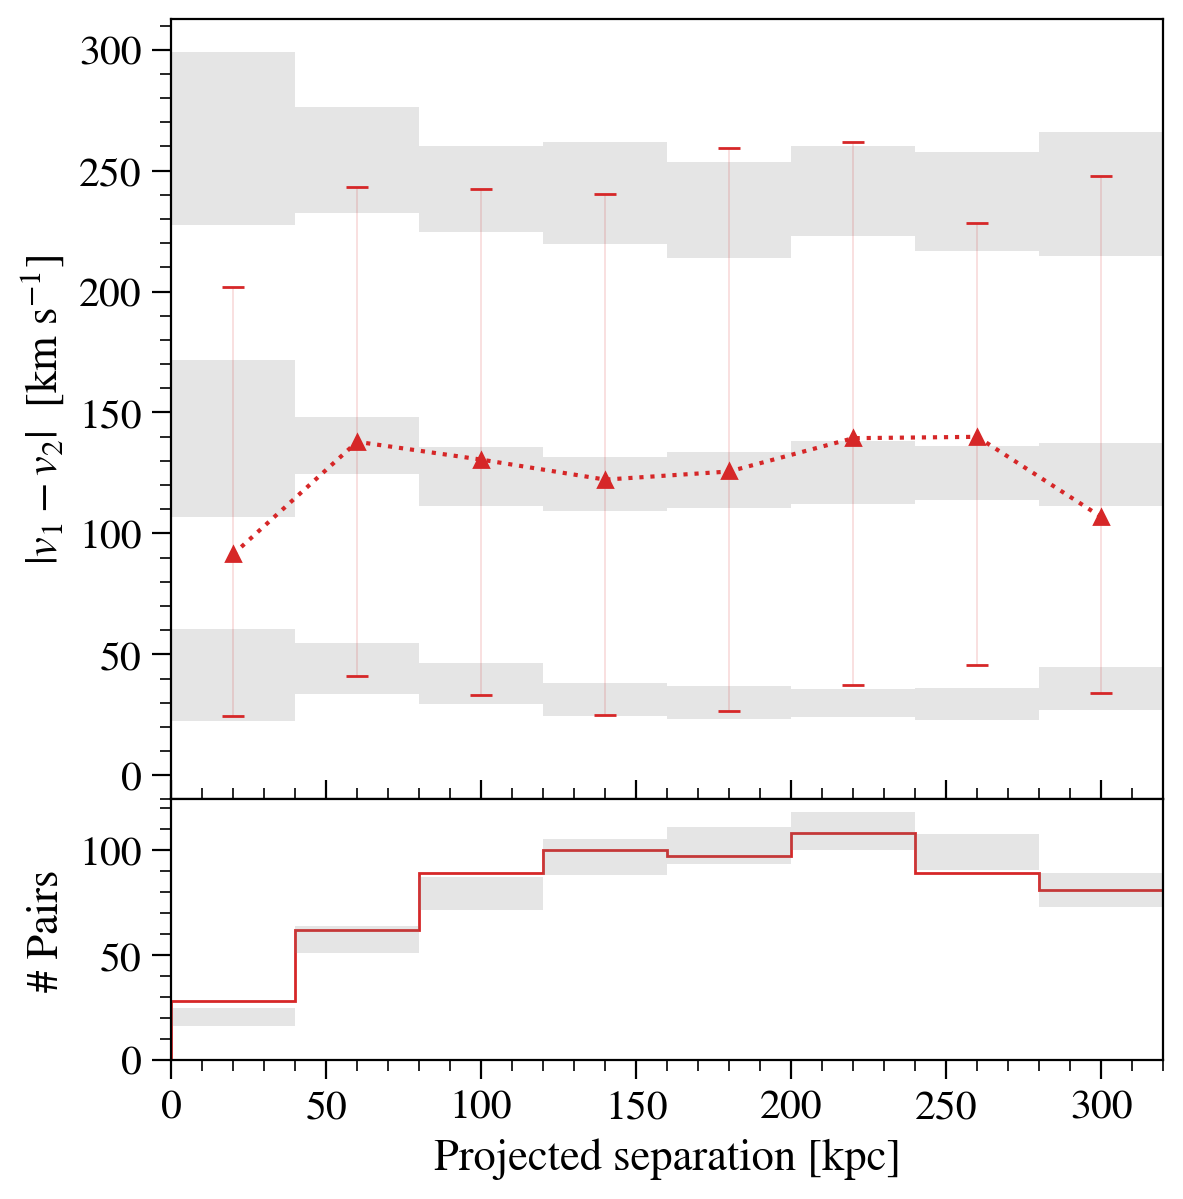

In [15]:
pairs = add_pa(pairs)
#pairs_lmc = pairs[np.isin(sats["HOSTID"][pairs["idx1"]], Query("most_massive_sat >= 8.5").filter(hosts, "HOSTID"))]

fig, ax = plt.subplots(2, 1, figsize=get_figsize(wide=False, ratio=1), height_ratios=(3,1))
ax = np.array([[None, ax[0]], [None, ax[1]]])
fig.set_constrained_layout_pads(hspace=0, h_pad=0)

x = (sbins[1:]+sbins[:-1])*0.5

t = Query().filter(pairs)
_, count, (y, y1, y2) = binned_percentile(t['sep'], t["dv"], bins=sbins, percentiles=[50, 16, 84])
ax[0,1].errorbar(x, y, (y-y1, y2-y), color="C3", marker="^", ls=":", elinewidth=0.1, capsize=4)
ax[1,1].stairs(count, sbins, color="C3")

ym = bn.nanmean(dv_rand, axis=0)
ye = bn.nanstd(dv_rand, axis=0)
x1 = np.linspace(sbins[0], sbins[-1], len(sbins)*2-1)
for i in range(3):
    ax[0,1].stairs(ym[i]+ye[i], sbins, baseline=(ym[i]-ye[i]), fill=True, alpha=0.2, color="gray")

ym = bn.nanmean(hist_sep_rand, axis=0)
ye = bn.nanstd(hist_sep_rand, axis=0)
ax[1,1].stairs(ym+ye, sbins, baseline=(ym-ye), fill=True, alpha=0.2, color="gray")

ax[0,1].tick_params(axis="x", which="both", direction="in")
ax[0,1].set_xticklabels([])
ax[0,1].set_xlim(sbins[0], sbins[-1]);
ax[0,1].set_ylim(-10, None);
ax[1,1].set_xlim(sbins[0], sbins[-1]);

ax[1,1].set_xlabel('Projected separation [kpc]')
ax[0,1].set_ylabel('$|v_1-v_2|$  [km s$^{-1}$]')
ax[1,1].set_ylabel('# Pairs')

plt.savefig('plots/sat_close_pairs.pdf')